# GPAW + WannierBerri: Altermagnet MnTe

It is assumed that the reader is familiar with the previous tutorial on bcc Fe with GPAW. In this tutorial we will show a special case, the crystal structure is anti-ferromagnetic.
MnTe has two Mn atoms per unit cell with opposite directions of magnetic moments. As a result in spin-up states, the Mn1 d-states are occupied, while the Mn2 d-states are empty. In the spin-down channel the situation is reversed. Thus, to wannierise only the valence bands, one may want to introduce different projections for the two spin channels.

In [2]:
import numpy as np
from ase import Atoms
from gpaw import GPAW, PW, FermiDirac, MixerSum
from wannierberri.parallel import Parallel, Serial

parallel_env= Parallel(num_cpus=16)
seed = "MnTe"

a = 4.134
c = 6.652
lattice = a * np.array([[1, 0, 0], [-1 / 2, np.sqrt(3) / 2, 0], [0, 0, c / a]])
positions = np.array(
    [
        [0, 0, 0],
        [0, 0, 1 / 2],
        [1 / 3, 2 / 3, 1 / 4],
        [2 / 3, 1 / 3, 3 / 4],
    ]
)

initializing ray with  {'num_cpus': 16}


2025-10-22 21:08:55,827	INFO worker.py:1918 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 



## Step 1: Gpaw calculation

### loading the GPAW calculators

If you want to skip the GPAW calculation, you can just load the pre-calculated calculators



In [15]:
calc_scf = GPAW(f"gpaw/{seed}-scf.gpw")
calc_nscf = GPAW(f"gpaw/{seed}-nscf-irred-664.gpw")
calc_bands = GPAW(f"gpaw/{seed}-bands-path.gpw")


### self-consistent calculation

In [ ]:
a = 4.134
c = 6.652
lattice = a * np.array([[1, 0, 0], [-1 / 2, np.sqrt(3) / 2, 0], [0, 0, c / a]])
positions = np.array(
    [
        [0, 0, 0],
        [0, 0, 1 / 2],
        [1 / 3, 2 / 3, 1 / 4],
        [2 / 3, 1 / 3, 3 / 4],
    ]
)
atoms = Atoms("Mn2Te2",
                cell=lattice,
                scaled_positions=positions,
                pbc=[1, 1, 1])

m = 4.7
magmoms = np.zeros(4)
magmoms[0] = +m
magmoms[1] = -m
atoms.set_initial_magnetic_moments(magmoms)

calc = GPAW(
    mode=PW(600),
    xc="PBE",
    kpts={"size": [6, 6, 4], "gamma": True},
    convergence={"density": 1e-6},
    mixer=MixerSum(0.25, 8, 100),
    setups={"Mn": ":d,4.0"},
    txt="MnTe_scf_norelax.txt"
)
atoms.calc = calc
atoms.get_potential_energy()
calc.write("{seed}-scf.gpw", mode="all")


### Non-self-consistent calculation in the irreducible Brillouin zone

Now we get the list of irreducible k-points (using irrep.SpaceGroup object) and perform a non-self-consistent calculation only on these k-points. 
Note, that here we use all symmetries of the crystal structure, even those which are broken by the magnetization direction, because they are still symmetries for each spin channel separately (including the time-reversal symmetry).

In [ ]:
from irrep.spacegroup import SpaceGroup
sg = SpaceGroup.from_gpaw(calc)
kpoints_irred = sg.get_irreducible_kpoints_grid([6, 6, 4])
calc_nscf = calc.fixed_density(
    kpts=kpoints_irred,
    symmetry={'symmorphic': False},
    nbands=60,
    convergence={'bands': 40},
    txt=f'{seed}-nscf.txt')
calc_nscf.write(f'{seed}-nscf-irred-664.gpw', mode='all')

typat used for spacegroup detection (accounting magmoms): [26]


### Compute the dft bandstructure along a high-symmetry path

This is done to compare with the wannierized bandstructure later.

In [ ]:
from wannierberri.grid import Path
# recip_lattice = 2*np.pi * np.linalg.inv(lattice).T
kz = 0.35 / (2*np.pi/c)
path = Path(lattice,
            nodes=[
                [2 / 3, -1 / 3, 0],
                [0, 0, 0],
                [-2 / 3, 1 / 3, 0],
                None,
                [-0.5, 0, kz],
                [0, 0, kz],
                [0.5, 0, kz],
            ],
            labels=[r"${\rm K}\leftarrow$",
                    r"$\Gamma$",
                    r"$\rightarrow{\rm K}$",
                    r"$\overline{\rm M}\leftarrow$",
                    r"$\overline{\Gamma}$",
                    r"$\rightarrow\overline{\rm M}$"],
            length=100)   # length [ Ang] ~= 2*pi/dk
kpoints = path.K_list
print (kpoints.shape)
print (kpoints)

calc_bands = calc_scf.fixed_density(
    nbands=30,
    symmetry='off',
    random=True,
    kpts=kpoints,
    txt=f'{seed}-bands-path.txt',
    convergence={'bands': 24})
calc_bands.write(f'{seed}-bands-path.gpw', mode='all')


(61, 3)
[[ 0.66666667 -0.33333333  0.        ]
 [ 0.625      -0.3125      0.        ]
 [ 0.58333333 -0.29166667  0.        ]
 [ 0.54166667 -0.27083333  0.        ]
 [ 0.5        -0.25        0.        ]
 [ 0.45833333 -0.22916667  0.        ]
 [ 0.41666667 -0.20833333  0.        ]
 [ 0.375      -0.1875      0.        ]
 [ 0.33333333 -0.16666667  0.        ]
 [ 0.29166667 -0.14583333  0.        ]
 [ 0.25       -0.125       0.        ]
 [ 0.20833333 -0.10416667  0.        ]
 [ 0.16666667 -0.08333333  0.        ]
 [ 0.125      -0.0625      0.        ]
 [ 0.08333333 -0.04166667  0.        ]
 [ 0.04166667 -0.02083333  0.        ]
 [ 0.          0.          0.        ]
 [-0.04166667  0.02083333  0.        ]
 [-0.08333333  0.04166667  0.        ]
 [-0.125       0.0625      0.        ]
 [-0.16666667  0.08333333  0.        ]
 [-0.20833333  0.10416667  0.        ]
 [-0.25        0.125       0.        ]
 [-0.29166667  0.14583333  0.        ]
 [-0.33333333  0.16666667  0.        ]
 [-0.375       0.

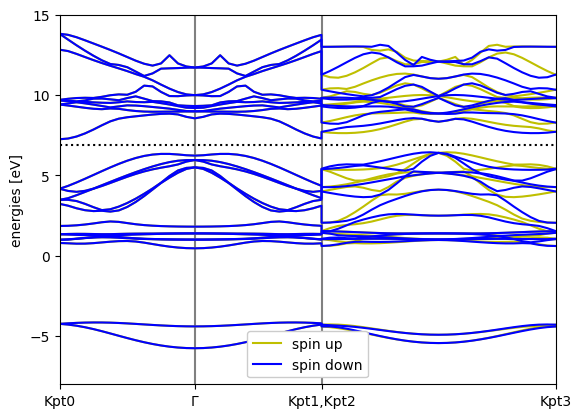

<Axes: ylabel='energies [eV]'>

In [14]:
bs_dft = calc_bands.band_structure()
bs_dft.plot(show=True, emin=-8,emax=15.0)

## Step 2: Wannierization

#### 2.1 select projections

In this case we use sp3d2 and t2g projections on each iron atom.  One can also use the conventional s,p,d orbitals. 

In [16]:
from irrep.spacegroup import SpaceGroup
from wannierberri.symmetry.projections import Projection, ProjectionsSet

sg = SpaceGroup.from_gpaw(calc_nscf)

positions_Mn = [[0, 0, 0],
                [0, 0, 1 / 2]]

positions_Te = [[1 / 3, 2 / 3, 1 / 4],
                [2 / 3, 1 / 3, 3 / 4]]

proj_Mn1_d = Projection(position_num=positions_Mn[0], orbital='d', spacegroup=sg)
proj_Mn2_d = Projection(position_num=positions_Mn[1], orbital='d', spacegroup=sg)

proj_Te_sp2 = Projection(position_num=positions_Te, orbital='sp2', spacegroup=sg, xaxis=[0, -1, 0], rotate_basis=True)
proj_Te_pz = Projection(position_num=positions_Te, orbital='pz', spacegroup=sg)

proj_set_up = ProjectionsSet([proj_Mn1_d, proj_Te_sp2, proj_Te_pz])
proj_set_down = ProjectionsSet([proj_Mn2_d, proj_Te_sp2, proj_Te_pz])



typat used for spacegroup detection (accounting magmoms): [25003, 25001, 52002, 52002]


### create the "w90 files"

Here we are NOT using the gpaw-wannier90 interface, and actually not creating the w90 files, but directly access the wavefunctions from the GPAW calculation, use symmetry operations from irrep, and create the necessary data to be used with wannierberri. Those files still retain the same naming convention as the w90 files for consistency, but htey are binary npz files, which are convenient to work with numpy


After creating those data, it is written to the disk, so that one can later load it. But be careful - if you change anything (e.g. the projections)  - do not forget to remove those files, otherwise you will load the old data! For that reason, here we set 'read_npz_list=[]' to force the creation of new data.

In [17]:
from wannierberri.w90files.w90data_soc import Wannier90dataSOC
w90data = Wannier90dataSOC.from_gpaw(
    seedname="wannier_soc",
    calculator=calc_nscf,
    projections_up=proj_set_up,
    projections_down=proj_set_down,
    mp_grid=(6, 6, 4),
    # read_npz_list=[],
    spacegroup=sg,
)

w90data.select_bands(win_min=-10,
                     win_max=50)

finding num points from 3 projections
got irreducible=None, mp_grid=(6, 6, 4), seedname=wannier_soc-spin-0, files=['mmn', 'eig', 'amn', 'symmetrizer'], read_npz_list=None, write_npz_list=None, projections=ProjectionsSet with 13 Wannier functions and 0 free variables
Projection 0, 0, 0:['d'] with 5 Wannier functions on 1 points (5 per site)
Projection 0.3333333333333333, 0.6666666666666666, 0.25:['sp2'] with 6 Wannier functions on 2 points (3 per site)
Projection 0.3333333333333333, 0.6666666666666666, 0.25:['pz'] with 2 Wannier functions on 2 points (1 per site), unk_grid=None, normalize=True
kpt_latt_grid=[[0.         0.         0.        ]
 [0.         0.         0.25      ]
 [0.         0.         0.5       ]
 [0.         0.16666667 0.        ]
 [0.         0.16666667 0.25      ]
 [0.         0.16666667 0.5       ]
 [0.         0.16666667 0.75      ]
 [0.         0.33333333 0.        ]
 [0.         0.33333333 0.25      ]
 [0.         0.33333333 0.5       ]
 [0.         0.33333333 0.

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/w90files/w90data.py:151: UserWarning: detected grid (np.int64(6), np.int64(6), np.int64(4)) od 144 kpoints, but only 24 kpoints are available.assuming that only irreducible kpoints are needed.
  warnings.warn(f"detected grid {grid} od {np.prod(grid)} kpoints, "
/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/w90files/w90data.py:185: UserWarning: Failed to read symmetrizer from wannier_soc-spin-0.symmetrizer.npz: [Errno 2] No such file or directory: 'wannier_soc-spin-0.symmetrizer.npz'
  warnings.warn(f"Failed to read symmetrizer from {fname}: {e}")


orbitals = ['d']
orbitals = ['sp2']
orbitals = ['pz']
calculating Wannier functions for d at [[0 0 0]]
calculating Wannier functions for sp2 at [[0.33333333 0.66666667 0.25      ]
 [0.66666667 0.33333333 0.75      ]]
calculating Wannier functions for pz at [[0.33333333 0.66666667 0.25      ]
 [0.66666667 0.33333333 0.75      ]]
D.shape [(24, 24, 5, 5), (24, 24, 6, 6), (24, 24, 2, 2)]
num_wann 13
D_wann_block_indices [[ 0  5]
 [ 5 11]
 [11 13]]
saving to wannier_soc-spin-0.symmetrizer.npz : 
saving to wannier_soc-spin-0.eig.npz : 
Creating amn. Using projections_set 
ProjectionsSet with 13 Wannier functions and 0 free variables
Projection 0, 0, 0:['d'] with 5 Wannier functions on 1 points (5 per site)
Projection 0.3333333333333333, 0.6666666666666666, 0.25:['sp2'] with 6 Wannier functions on 2 points (3 per site)
Projection 0.3333333333333333, 0.6666666666666666, 0.25:['pz'] with 2 Wannier functions on 2 points (1 per site)
saving to wannier_soc-spin-0.amn.npz : 
mpgrid = [6 6 4], 144
N

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/w90files/w90data.py:185: UserWarning: Failed to read symmetrizer from wannier_soc-spin-1.symmetrizer.npz: [Errno 2] No such file or directory: 'wannier_soc-spin-1.symmetrizer.npz'
  warnings.warn(f"Failed to read symmetrizer from {fname}: {e}")


orbitals = ['d']
orbitals = ['sp2']
orbitals = ['pz']
calculating Wannier functions for d at [[0.  0.  0.5]]
calculating Wannier functions for sp2 at [[0.33333333 0.66666667 0.25      ]
 [0.66666667 0.33333333 0.75      ]]
calculating Wannier functions for pz at [[0.33333333 0.66666667 0.25      ]
 [0.66666667 0.33333333 0.75      ]]
D.shape [(24, 24, 5, 5), (24, 24, 6, 6), (24, 24, 2, 2)]
num_wann 13
D_wann_block_indices [[ 0  5]
 [ 5 11]
 [11 13]]
saving to wannier_soc-spin-1.symmetrizer.npz : 
saving to wannier_soc-spin-1.eig.npz : 
Creating amn. Using projections_set 
ProjectionsSet with 13 Wannier functions and 0 free variables
Projection 0.0, 0.0, 0.5:['d'] with 5 Wannier functions on 1 points (5 per site)
Projection 0.3333333333333333, 0.6666666666666666, 0.25:['sp2'] with 6 Wannier functions on 2 points (3 per site)
Projection 0.3333333333333333, 0.6666666666666666, 0.25:['pz'] with 2 Wannier functions on 2 points (1 per site)
saving to wannier_soc-spin-1.amn.npz : 
mpgrid = [6

### Do the wannierization

at this step we also specify the frozen window, number of iterations, and whether to use site 
symmetry and localization. (when starting from irreducible BZ, site-symmetry is required anyway)

We also may use the outer window via w90data.select_bands if needed

In this case, both spin channels will be wannierised separately, starting from the same projections.There is also an option to specify different projections for different spin channels if needed. (See MnTe tutorial)

In [19]:
w90data.wannierise(
    froz_min=-10,
    froz_max=7,
    num_iter=300,
    print_progress_every=50,
    sitesym=True,
    localise=True,
)



Symmetrizer_Uirr initialized for ikirr=0, kpt=0, [0. 0. 0.] with 24 symmetries, max error in included blocks: 4.775301491256433e-07 ; excluded bands are [49 50 51] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=1, kpt=1, [0.   0.   0.25] with 12 symmetries, max error in included blocks: 3.381164304429173e-06 ; excluded bands are [48 49] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=2, kpt=2, [0.  0.  0.5] with 24 symmetries, max error in included blocks: 1.974197330420772e-06 ; excluded bands are [] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=3, kpt=3, [0.         0.16666667 0.        ] with 4 symmetries, max error in included blocks: 2.799612726714073e-07 ; excluded bands are [48 49 50 51] out of 52 total bands (accuracy threshold 1e-06)


/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sawf_kirr.py:165: UserWarning: Warning: max error in block 33 [47:48] is 3.381164304429173e-06, exceeding threshold 1e-06, and this is not among the  upper bands(48:52) bands, this may indicate inaccuracy in the input data
  warnings.warn(f"Warning: max error in block {i} [{start}:{end}] is {max_error_in_blocks[i]}, exceeding threshold {accuracy_threshold}, and this is not among the  upper"
/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sawf_kirr.py:165: UserWarning: Warning: max error in block 31 [46:48] is 1.974197330420772e-06, exceeding threshold 1e-06, and this is not among the  upper bands(48:52) bands, this may indicate inaccuracy in the input data
  warnings.warn(f"Warning: max error in block {i} [{start}:{end}] is {max_error_in_blocks[i]}, exceeding threshold {accuracy_threshold}, and this is not among the  upper"


Symmetrizer_Uirr initialized for ikirr=4, kpt=4, [0.         0.16666667 0.25      ] with 4 symmetries, max error in included blocks: 3.7372458106401275e-07 ; excluded bands are [49 50 51] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=5, kpt=5, [0.         0.16666667 0.5       ] with 4 symmetries, max error in included blocks: 9.306464534587413e-07 ; excluded bands are [49 50 51] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=6, kpt=6, [0.         0.16666667 0.75      ] with 4 symmetries, max error in included blocks: 8.359040398240567e-07 ; excluded bands are [49 50 51] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=7, kpt=7, [0.         0.33333333 0.        ] with 4 symmetries, max error in included blocks: 2.9180980241263033e-08 ; excluded bands are [49 50 51] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=8, kpt=8, [0.  

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sawf_kirr.py:165: UserWarning: Warning: max error in block 47 [47:48] is 3.57990449657817e-06, exceeding threshold 1e-06, and this is not among the  upper bands(48:52) bands, this may indicate inaccuracy in the input data
  warnings.warn(f"Warning: max error in block {i} [{start}:{end}] is {max_error_in_blocks[i]}, exceeding threshold {accuracy_threshold}, and this is not among the  upper"


Symmetrizer_Uirr initialized for ikirr=13, kpt=13, [0.  0.5 0.5] with 8 symmetries, max error in included blocks: 5.976570863867099e-08 ; excluded bands are [48 49 50 51] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=14, kpt=14, [0.16666667 0.16666667 0.        ] with 4 symmetries, max error in included blocks: 4.180302175212303e-07 ; excluded bands are [50 51] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=15, kpt=15, [0.16666667 0.16666667 0.25      ] with 2 symmetries, max error in included blocks: 1.1739862079479962e-16 ; excluded bands are [] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=16, kpt=16, [0.16666667 0.16666667 0.5       ] with 4 symmetries, max error in included blocks: 6.688390301510412e-07 ; excluded bands are [48 49 50 51] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=17, kpt=17, [0.16666667 0.33333333

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sawf_kirr.py:165: UserWarning: Warning: max error in block 9 [14:16] is 1.7675104934565142e-06, exceeding threshold 1e-06, and this is not among the  upper bands(48:52) bands, this may indicate inaccuracy in the input data
  warnings.warn(f"Warning: max error in block {i} [{start}:{end}] is {max_error_in_blocks[i]}, exceeding threshold {accuracy_threshold}, and this is not among the  upper"
/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sawf_kirr.py:165: UserWarning: Warning: max error in block 28 [43:45] is 1.7130895244994746e-06, exceeding threshold 1e-06, and this is not among the  upper bands(48:52) bands, this may indicate inaccuracy in the input data
  warnings.warn(f"Warning: max error in block {i} [{start}:{end}] is {max_error_in_blocks[i]}, exceeding threshold {accuracy_threshold}, and this is not among the  upper"
/home/stepan/github/wannier-berri-work/wann

####################################################################################################
starting WFs
----------------------------------------------------------------------------------------------------
wannier centers and spreads
----------------------------------------------------------------------------------------------------
  0.000000000000    0.000000000000    0.000000000000   |     0.453612612686
  0.000000000000    0.000000000000    0.000000000000   |     0.488675433049
  0.000000000000    0.000000000000    0.000000000000   |     0.488675433049
  0.000000000000    0.000000000000    0.000000000000   |     0.470020830251
  0.000000000000    0.000000000000    0.000000000000   |     0.470020830251
  0.701560854875    2.791812361245    1.687986300531   |     2.353922087855
 -0.701560854875    2.791812361245    1.687986300531   |     2.353922087855
  0.000000000000    1.576673316000    1.687986300531   |     2.353922087855
  1.365439145125    0.788336658000    4.96401369

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sawf_kirr.py:165: UserWarning: Warning: max error in block 33 [47:48] is 1.3130784851360061e-06, exceeding threshold 1e-06, and this is not among the  upper bands(48:52) bands, this may indicate inaccuracy in the input data
  warnings.warn(f"Warning: max error in block {i} [{start}:{end}] is {max_error_in_blocks[i]}, exceeding threshold {accuracy_threshold}, and this is not among the  upper"


Symmetrizer_Uirr initialized for ikirr=2, kpt=2, [0.  0.  0.5] with 24 symmetries, max error in included blocks: 5.736129865047892e-07 ; excluded bands are [] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=3, kpt=3, [0.         0.16666667 0.        ] with 4 symmetries, max error in included blocks: 9.579951910506201e-09 ; excluded bands are [48 49 50 51] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=4, kpt=4, [0.         0.16666667 0.25      ] with 4 symmetries, max error in included blocks: 4.305908219256872e-08 ; excluded bands are [49 50 51] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=5, kpt=5, [0.         0.16666667 0.5       ] with 4 symmetries, max error in included blocks: 1.842572016762308e-07 ; excluded bands are [49 50 51] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=6, kpt=6, [0.         0.16666667 0.75     

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sawf_kirr.py:165: UserWarning: Warning: max error in block 45 [46:47] is 1.7371188884375128e-06, exceeding threshold 1e-06, and this is not among the  upper bands(48:52) bands, this may indicate inaccuracy in the input data
  warnings.warn(f"Warning: max error in block {i} [{start}:{end}] is {max_error_in_blocks[i]}, exceeding threshold {accuracy_threshold}, and this is not among the  upper"


Symmetrizer_Uirr initialized for ikirr=10, kpt=10, [0.         0.33333333 0.75      ] with 4 symmetries, max error in included blocks: 3.799296949479876e-06 ; excluded bands are [48 49 50 51] out of 52 total bands (accuracy threshold 1e-06)


/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sawf_kirr.py:165: UserWarning: Warning: max error in block 46 [46:47] is 3.799296949479876e-06, exceeding threshold 1e-06, and this is not among the  upper bands(48:52) bands, this may indicate inaccuracy in the input data
  warnings.warn(f"Warning: max error in block {i} [{start}:{end}] is {max_error_in_blocks[i]}, exceeding threshold {accuracy_threshold}, and this is not among the  upper"


Symmetrizer_Uirr initialized for ikirr=11, kpt=11, [0.  0.5 0. ] with 8 symmetries, max error in included blocks: 1.191229412573126e-06 ; excluded bands are [48 49 50 51] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=12, kpt=12, [0.   0.5  0.25] with 4 symmetries, max error in included blocks: 1.3824749964370088e-07 ; excluded bands are [] out of 52 total bands (accuracy threshold 1e-06)


/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sawf_kirr.py:165: UserWarning: Warning: max error in block 47 [47:48] is 1.191229412573126e-06, exceeding threshold 1e-06, and this is not among the  upper bands(48:52) bands, this may indicate inaccuracy in the input data
  warnings.warn(f"Warning: max error in block {i} [{start}:{end}] is {max_error_in_blocks[i]}, exceeding threshold {accuracy_threshold}, and this is not among the  upper"


Symmetrizer_Uirr initialized for ikirr=13, kpt=13, [0.  0.5 0.5] with 8 symmetries, max error in included blocks: 7.302686515522201e-06 ; excluded bands are [48 49 50 51] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=14, kpt=14, [0.16666667 0.16666667 0.        ] with 4 symmetries, max error in included blocks: 6.279557009874495e-07 ; excluded bands are [49 50 51] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=15, kpt=15, [0.16666667 0.16666667 0.25      ] with 2 symmetries, max error in included blocks: 1.3947004136484323e-16 ; excluded bands are [] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=16, kpt=16, [0.16666667 0.16666667 0.5       ] with 4 symmetries, max error in included blocks: 1.1403355381199705e-08 ; excluded bands are [48 49 50 51] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=17, kpt=17, [0.16666667 0.3333

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sawf_kirr.py:165: UserWarning: Warning: max error in block 46 [46:47] is 1.018895160721902e-06, exceeding threshold 1e-06, and this is not among the  upper bands(48:52) bands, this may indicate inaccuracy in the input data
  warnings.warn(f"Warning: max error in block {i} [{start}:{end}] is {max_error_in_blocks[i]}, exceeding threshold {accuracy_threshold}, and this is not among the  upper"
/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sawf_kirr.py:165: UserWarning: Warning: max error in block 47 [47:48] is 7.302686515522201e-06, exceeding threshold 1e-06, and this is not among the  upper bands(48:52) bands, this may indicate inaccuracy in the input data
  warnings.warn(f"Warning: max error in block {i} [{start}:{end}] is {max_error_in_blocks[i]}, exceeding threshold {accuracy_threshold}, and this is not among the  upper"


Symmetrizer_Uirr initialized for ikirr=18, kpt=18, [0.16666667 0.33333333 0.25      ] with 2 symmetries, max error in included blocks: 1.1857187100668868e-16 ; excluded bands are [] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=19, kpt=19, [0.16666667 0.33333333 0.5       ] with 2 symmetries, max error in included blocks: 1.2412670766236366e-16 ; excluded bands are [] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=20, kpt=20, [0.16666667 0.33333333 0.75      ] with 2 symmetries, max error in included blocks: 1.1775693440128314e-16 ; excluded bands are [] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=21, kpt=21, [0.33333333 0.33333333 0.        ] with 12 symmetries, max error in included blocks: 0.0031316702788573665 ; excluded bands are [48 49] out of 52 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=22, kpt=22, [0.33333333 0.333333

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sawf_kirr.py:165: UserWarning: Warning: max error in block 9 [14:16] is 1.4487757124287662e-06, exceeding threshold 1e-06, and this is not among the  upper bands(48:52) bands, this may indicate inaccuracy in the input data
  warnings.warn(f"Warning: max error in block {i} [{start}:{end}] is {max_error_in_blocks[i]}, exceeding threshold {accuracy_threshold}, and this is not among the  upper"
/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sawf_kirr.py:165: UserWarning: Warning: max error in block 28 [43:45] is 2.035405963138839e-06, exceeding threshold 1e-06, and this is not among the  upper bands(48:52) bands, this may indicate inaccuracy in the input data
  warnings.warn(f"Warning: max error in block {i} [{start}:{end}] is {max_error_in_blocks[i]}, exceeding threshold {accuracy_threshold}, and this is not among the  upper"
/home/stepan/github/wannier-berri-work/wanni

####################################################################################################
starting WFs
----------------------------------------------------------------------------------------------------
wannier centers and spreads
----------------------------------------------------------------------------------------------------
  0.000000000000    0.000000000000    3.326000000000   |     0.453599406127
  0.000000000000    0.000000000000    3.326000000000   |     0.488672291672
  0.000000000000    0.000000000000    3.326000000000   |     0.488672291672
  0.000000000000    0.000000000000    3.326000000000   |     0.470025991047
  0.000000000000    0.000000000000    3.326000000000   |     0.470025991047
  0.701560487452    2.791812149113    1.637967928255   |     2.353924094187
 -0.701560487452    2.791812149113    1.637967928255   |     2.353924094187
 -0.000000000000    1.576673740264    1.637967928255   |     2.353924094187
  1.365439512548    0.788336870132    5.01403207

### Create the System object to be used in WannierBerri calculations

It is called "System_w90" class, although it now does not use the w90 wannierization, but the class is the same.

Unlike the non-SOC systems, here we also specify the direction of the magnetization. We can later easily chanbge this direction without redoing the wannierization.

In [20]:
from wannierberri.system.system_soc import SystemSOC
theta = 90
phi = 90

system_soc = SystemSOC.from_wannier90data_soc(w90data=w90data, berry=True, silent=False)
system_soc.set_soc_axis(theta=theta, phi=phi, alpha_soc=1.0, units="degrees")
system_soc.save_npz("system_soc")


setting Rvec
setting AA..
setting AA - OK
Real-space lattice:
 [[ 4.134       0.          0.        ]
 [-2.067       3.58014902  0.        ]
 [ 0.          0.          6.652     ]]
Number of wannier functions: 13
Number of R points: 267
Recommended size of FFT grid [6 6 4]
setting Rvec
setting AA..
setting AA - OK
Real-space lattice:
 [[ 4.134       0.          0.        ]
 [-2.067       3.58014902  0.        ]
 [ 0.          0.          6.652     ]]
Number of wannier functions: 13
Number of R points: 267
Recommended size of FFT grid [6 6 4]


/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/utility.py:68: UserWarning: usually need to provide either with real or reciprocal lattice.If you only want to generate a random symmetric tensor - that it fine
  warnings.warn("usually need to provide either with real or reciprocal lattice."


nspin in SOC: 2
setting the Rvectors with wannier centers (cart): 
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.32600000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.32600000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.32600000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.32600000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.32600000e+00]
 [ 7.05488710e-01  2.79408011e+00  1.63112851e+00]
 [ 7.05546670e-01  2.79411357e+00  1.69453500e+00]
 [-7.05488710e-01  2.79408011e+00  1.63112851e+00]
 [-7.05546670e-01  2.79411357e+00  1.69453500e+00]
 [ 2.00006889e-16  1.57213782e+00  1.63112851e+00]
 [-1.16724460e-17  1.57207089e+00  1.69453500e+00]
 [ 1.36151129e+00  7.86068910e-01  5.02087149e+00]
 [ 1.36145333e+00  7.86035446e-01  4.95746500e+00]
 [ 2.77248871e

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sym_wann_2.py:258: UserWarning: symmetrization of matrices {'dV_soc_wann_0_0'} is not tested. use on your own risk
  warnings.warn(f"symmetrization of matrices {unknown} is not tested. use on your own risk")
/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sym_wann_2.py:258: UserWarning: symmetrization of matrices {'dV_soc_wann_1_1'} is not tested. use on your own risk
  warnings.warn(f"symmetrization of matrices {unknown} is not tested. use on your own risk")
/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/symmetry/sym_wann_2.py:258: UserWarning: symmetrization of matrices {'overlap_up_down', 'dV_soc_wann_0_1'} is not tested. use on your own risk
  warnings.warn(f"symmetrization of matrices {unknown} is not tested. use on your own risk")


using magmoms 
 [[ 0.00000000e+00  0.00000000e+00  4.40436811e+00]
 [-0.00000000e+00 -0.00000000e+00 -4.40436811e+00]
 [-0.00000000e+00 -0.00000000e+00 -2.92436898e-10]
 [-0.00000000e+00 -0.00000000e+00 -2.92436898e-10]]
using magmoms 
 [[ 2.69689765e-16  4.40436811e+00  2.69689765e-16]
 [-2.69689765e-16 -4.40436811e+00 -2.69689765e-16]
 [-1.79065955e-26 -2.92436898e-10 -1.79065955e-26]
 [-1.79065955e-26 -2.92436898e-10 -1.79065955e-26]]
Saving SystemSOC to system_soc
saving system of class SystemSOC to system_soc
 properties: ['num_wann', 'real_lattice', 'iRvec', 'periodic', 'is_phonon', 'wannier_centers_cart', 'pointgroup', 'cell']
saving num_wann to system_soc/num_wann.npz
saving real_lattice to system_soc/real_lattice.npz
saving iRvec to system_soc/iRvec.npz
saving periodic to system_soc/periodic.npz
saving is_phonon to system_soc/is_phonon.npz
saving wannier_centers_cart to system_soc/wannier_centers_cart.npz
saving pointgroup to system_soc/pointgroup.npz
saving cell to system_soc

### Compute the wannierized bandstructure with SOC along the high-symmetry path

In [10]:
from wannierberri.grid import Path
from wannierberri.evaluate_k import evaluate_k_path
from wannierberri.system.system_soc import SystemSOC
system_soc = SystemSOC.from_npz("system_soc")
kz = 0.35 / (2*np.pi/c)
path = Path(lattice,
            nodes=[
                [2 / 3, -1 / 3, 0],
                [0, 0, 0],
                [-2 / 3, 1 / 3, 0],
                None,
                [-0.5, 0, kz],
                [0, 0, kz],
                [0.5, 0, kz],
            ],
            labels=[r"${\rm K}\leftarrow$",
                    r"$\Gamma$",
                    r"$\rightarrow{\rm K}$",
                    r"$\overline{\rm M}\leftarrow$",
                    r"$\overline{\Gamma}$",
                    r"$\rightarrow\overline{\rm M}$"],
            length=300)   # length [ Ang] ~= 2*pi/dk

bands_wannier_soc= evaluate_k_path(system_soc, path=path, quantities=["spin"], parallel=parallel_env)
bands_wannier_up = evaluate_k_path(system_soc.system_up, path=path, parallel=parallel_env)
bands_wannier_dw = evaluate_k_path(system_soc.system_down, path=path, parallel=parallel_env)
                                

loading real_lattice - Ok!
loading wannier_centers_cart - Ok!
loading pointgroup - Ok!
loading iRvec - Ok!
loading periodic - Ok!
loading is_phonon - Ok!
loading num_wann - Ok!
loading R_matrix Ham - Ok!
loading R_matrix AA - Ok!
loading real_lattice - Ok!
loading wannier_centers_cart - Ok!
loading pointgroup - Ok!
loading iRvec - Ok!
loading periodic - Ok!
loading is_phonon - Ok!
loading num_wann - Ok!
loading R_matrix Ham - Ok!
loading R_matrix AA - Ok!
Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x74c0905060c0>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "spin" : <wannierberri.calculators.tabulate.Spin object at 0x74c0e9e8a540> :  Spin expectation :math:` \langle u | \mathbf{\sigma} | u \rangle`

 "Energy" : <wannierberri.

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/utility.py:68: UserWarning: usually need to provide either with real or reciprocal lattice.If you only want to generate a random symmetric tensor - that it fine
  warnings.warn("usually need to provide either with real or reciprocal lattice."
/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/grid/path.py:163: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


time for processing    181 K-points on  16 processes:     0.3538 ; per K-point          0.0020 ; proc-sec per K-point          0.0313
time1 =  0.0051348209381103516
Totally processed 181 K-points 
run() finished
Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x74c0905060c0>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x74c0906187d0> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x74c0905060c0>
All calculators are compatible
Symmetrization swit

## Plot the Bandstructure with and without SOC

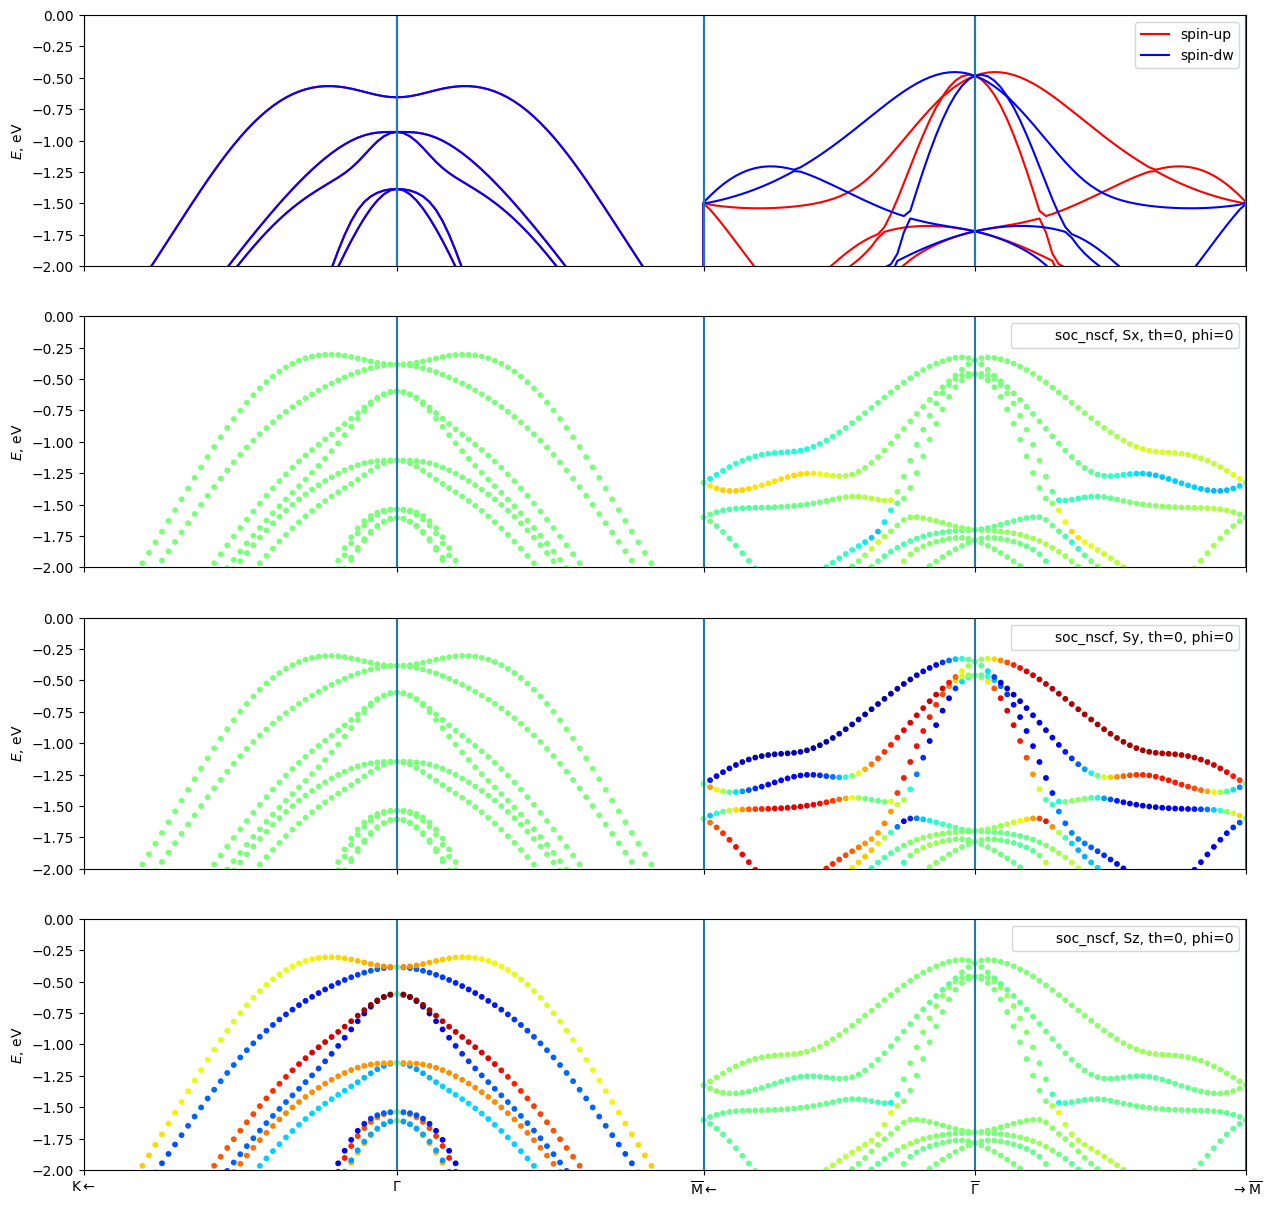

In [12]:
from matplotlib import pyplot as plt

EF = 6.885145845031927

fig, axes = plt.subplots(4, 1, sharey=True, sharex=True, figsize=(15, 15))

for i in range(3):
    component = "xyz"[i]
    bands_wannier_soc.plot_path_fat(path=path,
                       Eshift=EF,
                       quantity="spin",
                       component=component,
                       mode="color",
                       label=f"soc_nscf, S{component}, th={theta}, phi={phi}",
                        axes=axes[1 + i],
                       fatmax=10,
                        linecolor="orange",
                        close_fig=False,
                        show_fig=False,
                        kwargs_line=dict(linestyle='-', lw=0.0),
    )


bands_wannier_up.plot_path_fat(path=path,
                       Eshift=EF,
                       axes=axes[0],
                       label="spin-up",
                       linecolor="red",
                       close_fig=False,
                       show_fig=False,
)

bands_wannier_dw.plot_path_fat(path=path,
                       label="spin-dw",
                       axes=axes[0],
                       Eshift=EF,
                       linecolor="blue",
                       close_fig=False,
                       show_fig=False,)

plt.ylim(-2,0)
plt.show()


## AHC

### magnetic moments along "y" direction

Below we evaluate only the "internal" (which depend only on the Hamiltonian) contributions to the anomalous Hall conductivity (AHC), how to include the "external" contributions is explained in the previous tutorial on bcc Fe.

In [13]:
import os
import numpy as np
import wannierberri as wb
from wannierberri.system.system_soc import SystemSOC


system_soc_y = SystemSOC.from_npz("system_soc")
theta=90
phi=90
system_soc_y.set_soc_axis(theta=theta, phi=phi, units="degrees")

grid = wb.grid.Grid(system_soc_y, NK=200)

EF = 6.885145845031927
tetra = False

Efermi = np.linspace(EF - 2, EF, 1001)

os.makedirs("results", exist_ok=True)
result_int = wb.run(system_soc_y,
        grid=grid,
        parallel=parallel_env,
        fout_name=f"results/{seed}-soc-y",
        calculators={"ahc_int": wb.calculators.static.AHC(Efermi=Efermi, tetra=tetra, kwargs_formula={"external_terms": False})},
        adpt_num_iter=50,
        restart=False,
        print_progress_step=5,
        )


loading real_lattice - Ok!
loading wannier_centers_cart - Ok!
loading pointgroup - Ok!
loading iRvec - Ok!
loading periodic - Ok!
loading is_phonon - Ok!
loading num_wann - Ok!
loading R_matrix Ham - Ok!
loading R_matrix AA - Ok!
loading real_lattice - Ok!
loading wannier_centers_cart - Ok!
loading pointgroup - Ok!
loading iRvec - Ok!
loading periodic - Ok!
loading is_phonon - Ok!
loading num_wann - Ok!
loading R_matrix Ham - Ok!
loading R_matrix AA - Ok!


/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/utility.py:68: UserWarning: usually need to provide either with real or reciprocal lattice.If you only want to generate a random symmetric tensor - that it fine
  warnings.warn("usually need to provide either with real or reciprocal lattice."


using magmoms 
 [[ 2.69689765e-16  4.40436811e+00  2.69689765e-16]
 [-2.69689765e-16 -4.40436811e+00 -2.69689765e-16]
 [-1.79065955e-26 -2.92436898e-10 -1.79065955e-26]
 [-1.79065955e-26 -2.92436898e-10 -1.79065955e-26]]
Minimal symmetric FFT grid :  [11 11  7]
Starting run()
Using the follwing calculators : 
############################################################

 'ahc_int'  :  <wannierberri.calculators.static.AHC object at 0x74c0e06bb140>  : Anomalous Hall conductivity (:math:`s^3 \cdot A^2 / (kg \cdot m^3) = S/m`)

        | With Fermi sea integral Eq(11) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`O = -e^2/\hbar \int [dk] \Omega f`
        | Instruction: :math:`j_\alpha = \sigma_{\alpha\beta} E_\beta = \epsilon_{\alpha\beta\delta} O_\delta E_\beta`
############################################################
Calculation on  grid - checking calculators for compatibility
ahc_int <wannierberri.calculators.static.AHC object at 0x74c0e0

### plot AHC vs energy

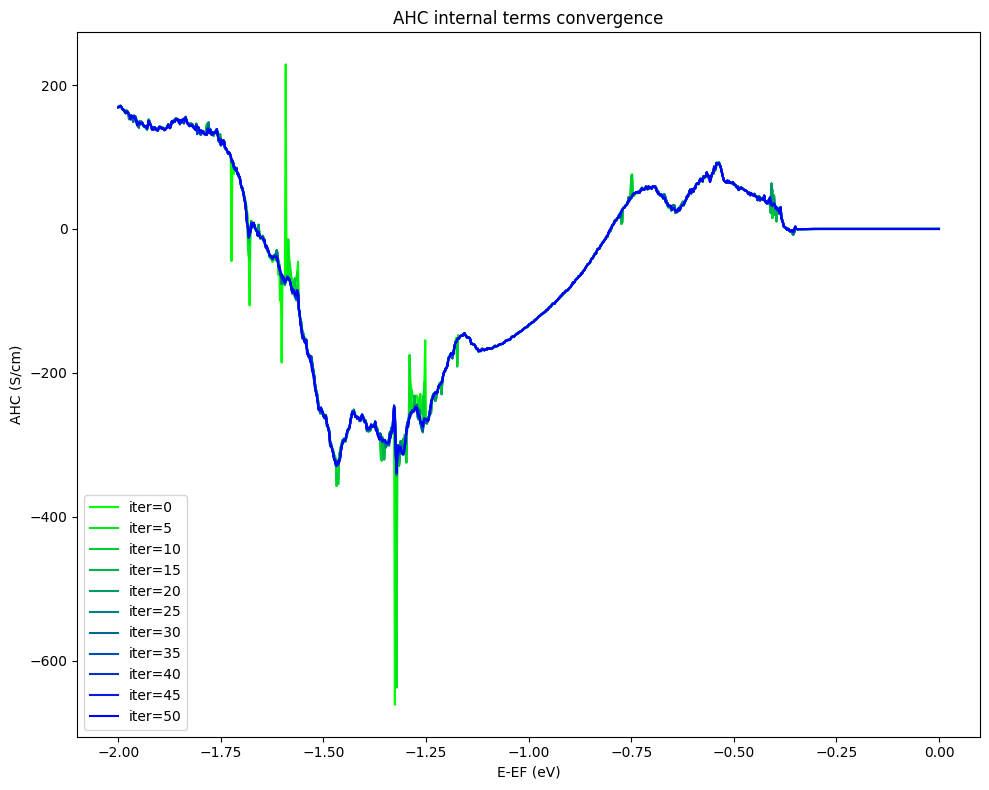

In [34]:
from matplotlib import pyplot as plt
import numpy as np
theta=0
phi=0


fig, axes = plt.subplots(1, 1, sharey=False, sharex=True, figsize=(10, 8))
axes=[axes]
for i in range(0,51,5):
    color = (0, 1-i/50, i/50)
    res =  np.load(f"results/MnTe-soc-y-ahc_int_iter-{i:04d}.npz")
    Efermi = res['Energies_0']
    ahc = res["data"]
    axes[0].plot(Efermi - EF, ahc[:,2]/100, label=f"iter={i}", color=color)
axes[0].set_title("AHC internal terms convergence")
# axes[0].set_ylim(-1000, 0)
axes[0].set_xlabel("E-EF (eV)")
axes[0].set_ylabel("AHC (S/cm)")
axes[0].legend()
plt.tight_layout()
plt.savefig("ahc_convergence.png", dpi=300)

We can observe 3 things, which are generally true, not only for AHC, but for most other effects:
1. The internal terms converge slower than the external ones.
2. The external terms usually give a smaller contribution. Often (but not always) it is negligible. However, check it for a particular material and effect.
3. The external terms take more time to evaluate per k-point. 

Thus, it makes sense to evaluate them separately, using different k-point grids and number of iterations for the adaptive integration.

## Other directions of magnetic moments

We could try to calculate the AHC when the magnetic moments are along "z" or "x" directions. However, we can see that in those cases the point group contains symmetries which force the AHC to be zero. 
This can be demonstrated by the following way:

In [38]:
from irrep.spacegroup import SpaceGroup
from wannierberri.symmetry.point_symmetry import PointGroup

#  x direction
mg = SpaceGroup.from_cell(real_lattice=lattice, positions=positions, typat=[1,1,2,2], magmom=[[1,0,0],[-1,0,0],[0,0,0],[0,0,0]])
# mg.show()
pointgroup = PointGroup(spacegroup=mg)
print (f"components of AHC for magnetic moments along x direction: {pointgroup.get_symmetric_components(rank=1, TRodd=True, Iodd=False)}")

mg = SpaceGroup.from_cell(real_lattice=lattice, positions=positions, typat=[1,1,2,2], magmom=[[0,1,0],[0,-1,0],[0,0,0],[0,0,0]])
# mg.show()
pointgroup = PointGroup(spacegroup=mg)
print (f"components of AHC for magnetic moments along y direction: {pointgroup.get_symmetric_components(rank=1, TRodd=True, Iodd=False)}")

mg = SpaceGroup.from_cell(real_lattice=lattice, positions=positions, typat=[1,1,2,2], magmom=[[0,0,1],[0,0,-1],[0,0,0],[0,0,0]])
# mg.show()
pointgroup = PointGroup(spacegroup=mg)
print (f"components of AHC for magnetic moments along z direction: {pointgroup.get_symmetric_components(rank=1, TRodd=True, Iodd=False)}")

components of AHC for magnetic moments along x direction: ['0=x=y=z']
components of AHC for magnetic moments along y direction: ['0=x=y', 'z']
components of AHC for magnetic moments along z direction: ['0=x=y=z']
